### Load required libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
alldata = pd.read_csv('./alldata/21/GECExport_LLY_2018_01_01_TO_2019_12_30.csv')
alldata['ts'] = pd.to_datetime(alldata['ts']) # change the object type to date type. 
alldata = alldata.set_index('ts')
alldata.head()

,instanceID,instanceIDGEC,Wind_speed,Energy_Export,Power,Ambient_temperature,High_speed_bearing_temperature,Rotor_speed,Nacelle_position,Generator_RPM,Gear_oil_temperature,Generator_temperature
ts,,,,,,,,,,,,
2018-01-01 00:00:00,LLY_WTG21,446,11.9,0.0,0.0,20.0,32.0,0.0,172.0,0.0,33.0,32.0
2018-01-01 00:10:00,LLY_WTG21,446,12.4,0.0,0.0,19.0,32.0,0.0,172.0,0.0,33.0,32.0
2018-01-01 00:20:00,LLY_WTG21,446,12.4,0.0,0.0,19.0,31.0,0.0,172.0,0.0,33.0,32.0
2018-01-01 00:30:00,LLY_WTG21,446,12.5,0.0,0.0,19.0,31.0,0.0,172.0,0.0,32.0,31.0
2018-01-01 00:40:00,LLY_WTG21,446,11.8,0.0,0.0,19.0,30.0,0.0,172.0,0.0,32.0,31.0


In [3]:
alldata = alldata.fillna(0)

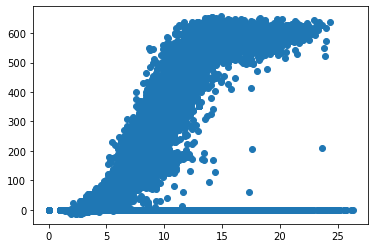

In [36]:
alldata_Power = alldata["Power"].values
alldata_wind = alldata["Wind_speed"].values
plt.scatter(alldata_wind, alldata_Power)

### Remove low output power values

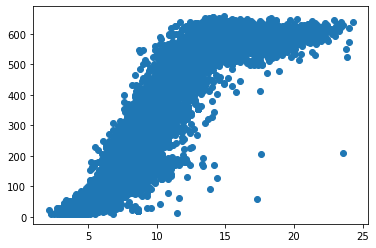

In [4]:
alldata = alldata[~(alldata['Power'] < 10)]
# alldata.loc[(alldata['Power'] >= 0) & (alldata['Power'] < 10) & (alldata['Wind_speed'] > 5),'Wind_speed'] = 0
alldata_Power = alldata["Power"].values
alldata_wind = alldata["Wind_speed"].values
plt.scatter(alldata_wind, alldata_Power)


### Remove outliers

In [9]:
rest_data = alldata[~((80 * alldata['Wind_speed'] - 800 - alldata['Power'] > 0)
                            & (alldata['Wind_speed'] > 10) & (alldata['Wind_speed'] <= 16))]

alldata = rest_data[~((rest_data['Power'] < 480) & (rest_data['Wind_speed'] >= 16)
                          & (rest_data['Wind_speed'] < 25))]
# based on the power curve

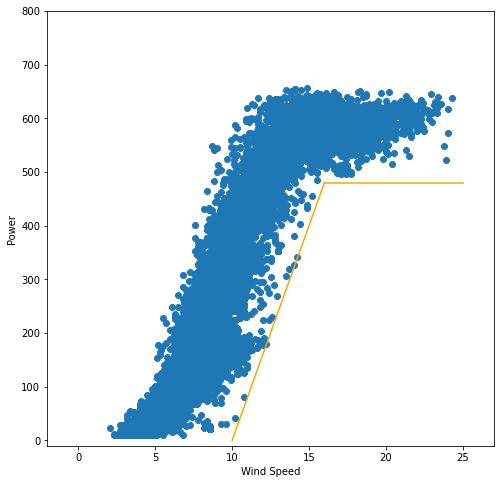

In [10]:
rest_Power = alldata["Power"].values
rest_wind = alldata["Wind_speed"].values

fig = plt.figure(num=1, figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.scatter(rest_wind, rest_Power)
ax1.set_xlim(-2, 27)
ax1.set_ylim(-10, 800)
ax1.set_xlabel('Wind Speed')
ax1.set_ylabel('Power')

x = np.linspace(10, 16, 100)
y = 80*x - 800
ax1.plot(x, y, c='orange')

xx = np.linspace(16, 25, 100)
yy = 0.0001*xx + 480
ax1.plot(xx, yy, c='orange')

plt.show()

### Evolution plot

In [11]:
day_df = alldata.resample('d').mean()
day_df.drop('instanceIDGEC', axis = 1, inplace = True)
day_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 728 entries, 2018-01-02 to 2019-12-30
Freq: D
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Wind_speed                      719 non-null    float64
 1   Energy_Export                   719 non-null    float64
 2   Power                           719 non-null    float64
 3   Ambient_temperature             719 non-null    float64
 4   High_speed_bearing_temperature  719 non-null    float64
 5   Rotor_speed                     719 non-null    float64
 6   Nacelle_position                719 non-null    float64
 7   Generator_RPM                   719 non-null    float64
 8   Gear_oil_temperature            719 non-null    float64
 9   Generator_temperature           719 non-null    float64
dtypes: float64(10)
memory usage: 62.6 KB


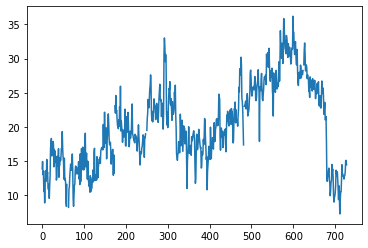

In [12]:
Ambient_temperature = day_df["Ambient_temperature"].values
plt.plot(Ambient_temperature)

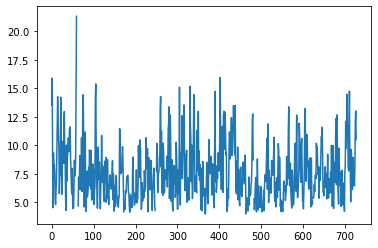

In [13]:
wind = day_df["Wind_speed"].values
plt.plot(wind)

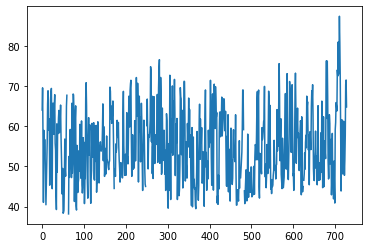

In [14]:
High_speed_bearing_temperature = day_df["High_speed_bearing_temperature"].values
plt.plot(High_speed_bearing_temperature)

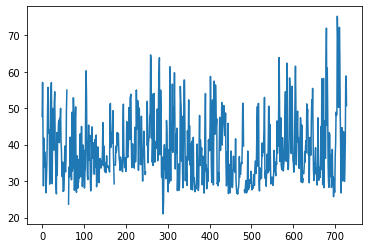

In [15]:
Gear_oil_temperature = day_df["Gear_oil_temperature"].values
plt.plot(Gear_oil_temperature)

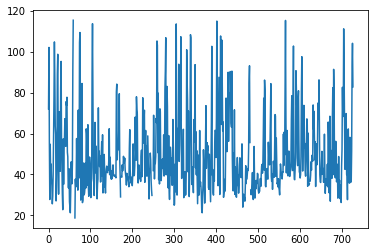

In [16]:
Generator_temperature = day_df["Generator_temperature"].values
plt.plot(Generator_temperature)

In [20]:
hour_df = alldata.resample('h').mean()

### Model development

In [21]:
features_considered = ['Power', 'Ambient_temperature', 'High_speed_bearing_temperature', 'Wind_speed','Gear_oil_temperature']

In [22]:
features = hour_df[features_considered]
features.head()

,Power,Ambient_temperature,High_speed_bearing_temperature,Wind_speed,Gear_oil_temperature
ts,,,,,
2018-01-02 15:00:00,229.000000,11.500000,23.500000,8.200000,16.000000
2018-01-02 16:00:00,325.833333,14.333333,60.500000,9.616667,36.833333
2018-01-02 17:00:00,318.500000,12.000000,62.166667,9.433333,42.166667
2018-01-02 18:00:00,234.333333,11.833333,61.666667,8.466667,42.000000
2018-01-02 19:00:00,493.333333,12.000000,64.166667,12.833333,46.166667


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000259D827A708>,
      dtype=object)

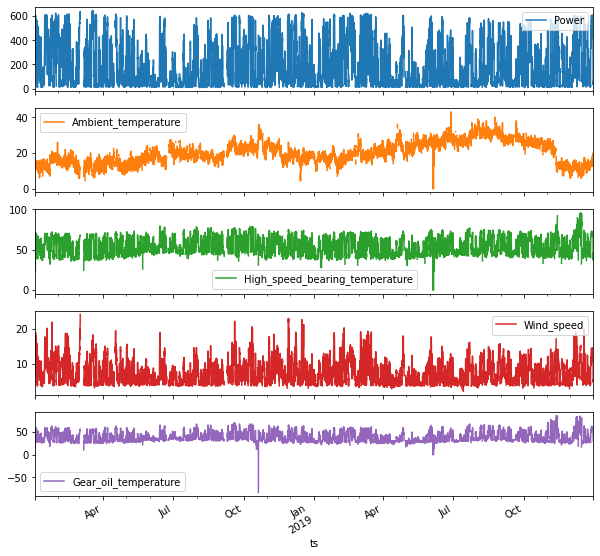

In [23]:
features.plot(subplots=True, figsize = (10, 10))

In [50]:
TRAIN_SPLIT = 11000

In [51]:
dataset = features.values
data_mean = dataset[2000:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[2000:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

#### Given a list consecutive inputs, the split method will convert them to a window of inputs and a window of labels.

In [52]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [53]:
past_history = 120
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset[:, :-1], dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset[:, :-1], dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [54]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 4)


In [55]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

### Build LSTM

In [56]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [57]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


#### Training process

In [58]:
EPOCHS = 30
EVALUATION_INTERVAL = 20

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=5)

Epoch 1/30
20/20 [==============================] - 2s 90ms/step - loss: 0.5287 - val_loss: 0.4455
Epoch 2/30
20/20 [==============================] - 1s 72ms/step - loss: 0.3798 - val_loss: 0.4020
Epoch 3/30
20/20 [==============================] - 1s 67ms/step - loss: 0.3282 - val_loss: 0.3585
Epoch 4/30
20/20 [==============================] - 1s 70ms/step - loss: 0.3029 - val_loss: 0.3066
Epoch 5/30
20/20 [==============================] - 1s 67ms/step - loss: 0.2678 - val_loss: 0.3714
Epoch 6/30
20/20 [==============================] - 1s 65ms/step - loss: 0.2634 - val_loss: 0.2880
Epoch 7/30
20/20 [==============================] - 1s 67ms/step - loss: 0.2569 - val_loss: 0.3323
Epoch 8/30
20/20 [==============================] - 1s 64ms/step - loss: 0.2448 - val_loss: 0.3238
Epoch 9/30
20/20 [==============================] - 1s 65ms/step - loss: 0.2380 - val_loss: 0.3250
Epoch 10/30
20/20 [==============================] - 1s 64ms/step - loss: 0.2393 - val_loss: 0.3005
Epoch 11/

In [59]:
single_step_model.save('./LLY01-try1/model21_regression')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./LLY01-try1/finalmodel_02tf\assets


In [60]:
def create_time_steps(length):
  return list(range(-length, 0))

In [61]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

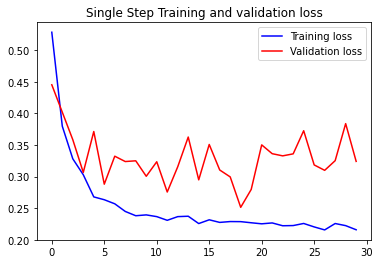

In [62]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [63]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

### Make prediction

In [80]:
x_test_single, y_test_single = multivariate_data(dataset[:, :-1], dataset[:, 4],
                                               8000, 14482, past_history,
                                               future_target, STEP,
                                               single_step=True)
print(x_test_single.shape)

(6362, 120, 4)


In [81]:
test_data_single = tf.data.Dataset.from_tensor_slices((x_test_single, y_test_single))
test_data_single = test_data_single.batch(BATCH_SIZE).repeat()

In [ ]:
predictlist = []
for i in range(8000, 14482):
    x_test_single, y_test_single = multivariate_data(dataset[:, :-1], dataset[:, 3],
                                               i, i+121, past_history,
                                               future_target, STEP,
                                               single_step=True)
    test_data_single = tf.data.Dataset.from_tensor_slices((x_test_single, y_test_single))
    test_data_single = test_data_single.batch(BATCH_SIZE).repeat()
    for x, y in test_data_single.take(1):
        aaa = single_step_model.predict(x)[0]
        predictlist.append(aaa)

In [84]:
len(predictlist)

6482

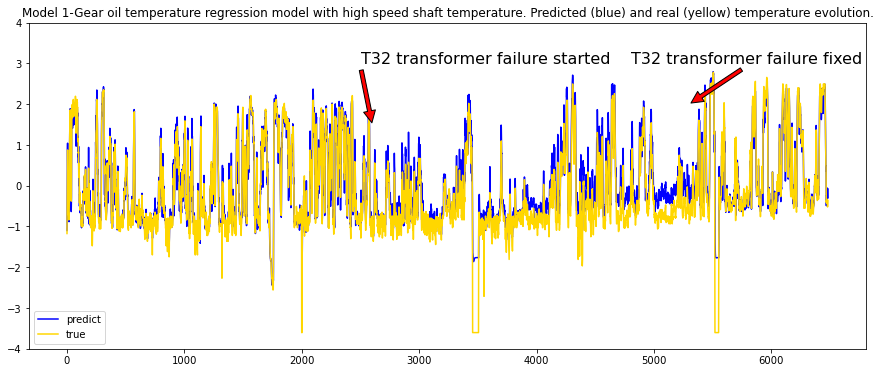

In [91]:
fig = plt.figure(num=1, figsize=(15,6))
ax1 = fig.add_subplot(111)
ax1.plot(predictlist, 'b', label = "predict")
ax1.plot(bbb, 'gold', label = "true")
ax1.legend(loc = 3)

ax1.annotate('T32 transformer failure started', xy=(2600, 1.5), xytext=(2500, 3),
            xycoords='data', fontsize = 16,
            arrowprops=dict(facecolor='red', shrink=0.03)
            )
ax1.annotate('T32 transformer failure fixed', xy=(5300, 2), xytext=(4800, 3),
            xycoords='data', fontsize = 16,
            arrowprops=dict(facecolor='red', shrink=0.03)
            )
ax1.set_ylim(-4, 4)

ax1.set_title('Model 1-Gear oil temperature regression model with high speed shaft temperature. Predicted (blue) and real (yellow) temperature evolution.')
plt.show()
